In [1]:
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt 
%matplotlib inline
import pandas as pd
from datetime import date, timedelta
from pandas import DataFrame
import sqlalchemy as sq
import numpy as np 
import math
import time
import scipy as scipy
from scipy import stats
import seaborn as sns
from sklearn import linear_model, metrics, preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import KFold,train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from modelselector import EstimatorSelectionHelper
from sklearn import svm
from ggplot import *
import statsmodels.api as sm
import xgboost as xgb
from xgboost import XGBRegressor
import gc

Using Theano backend.


In [2]:
data=pd.read_csv('/data/pratik/tensor/ad_clean.csv',error_bad_lines=False)
#data2=pd.read_csv('/data/pratik/tensor/sessions.csv',error_bad_lines=False)
#data=data1.merge(data2,how='left',on='date')

In [3]:
bag_summary=data.groupby(['brand','article_type','gender']).agg({'qty_sold' : np.sum})
bag_summary.reset_index(inplace=True)
bag_summary.sort_values(by='qty_sold',ascending=False).head(n=10)

brand  article_type gender  qty_sold
12280               Roadster       Tshirts    Men    481175
12261               Roadster        Shirts    Men    284597
1215                   Anouk        Kurtas  Women    142702
9568             Moda Rapido       Tshirts    Men    140019
12232               Roadster  Casual Shoes    Men    128356
12247               Roadster         Jeans    Men    122134
15699                      W        Kurtas  Women    121782
263                      AKS        Kurtas  Women    118251
8392                   Libas        Kurtas  Women    118011
6141   HRX by Hrithik Roshan       Tshirts    Men    100348

In [ ]:
bag_summary[bag_summary['article_type']=='Watches'].sort_values(by='qty_sold',ascending=False).head(n=10)

In [4]:
data_roadster_tshirts=data[(data['brand']=='Roadster') & (data['article_type']=='Tshirts') & (data['gender']=='Men') ]

In [5]:
data_roadster_tshirts.to_csv('raw_data.csv',index=False)

In [6]:
univariate=data_roadster_tshirts.describe(percentiles=[.01,.05,.1,.15,.2,.3,.4,.5,.6,.7,.8,.9,.95,.97,.99]).transpose()
univariate.to_csv('univariate.csv')
univariate

count          mean           std           min  \
date                 163.0  2.017036e+07  1.622962e+02  2.017011e+07   
qty_sold             163.0  2.951994e+03  8.062148e+02  1.148000e+03   
live_styles          163.0  1.380877e+03  1.177678e+02  1.067000e+03   
list_count           163.0  7.801091e+06  2.405062e+06  3.020236e+06   
inventory            163.0  2.540234e+05  7.905647e+04  1.404670e+05   
input_td             163.0  4.034969e+01  4.152247e+00  1.700000e+01   
output_td            163.0  4.109880e-01  4.161369e-02  3.081375e-01   
output_cd            163.0  2.078405e-02  1.291150e-02  1.437492e-03   
return_perc          163.0  1.268474e-01  5.608073e-02  0.000000e+00   
lp_screens           163.0  7.198160e+01  4.022199e+01  0.000000e+00   
pi_score             163.0  3.830057e+03  1.411352e+03  0.000000e+00   
brokeness            163.0  4.237484e-01  7.871297e-02  1.477717e-01   
freshness            163.0  3.582724e-01  2.649012e-01  9.448819e-03   
styles_age_0_30      163.0  1.172980e-01  4.438070e-02  3.485477e-02   
styles_age_31_60     163.0  1.202117e-01  5.812434e-02  3.109541e-02   
styles_age_61_90     163.0  8.976919e-02  6.158334e-02  1.763668e-03   
styles_age_91_120    163.0  6.034158e-02  5.521012e-02  2.334630e-03   
styles_age_121_150   163.0  4.368627e-02  4.388628e-02  1.355932e-03   
styles_age_180plus   163.0  4.647108e-01  9.590568e-02  1.565136e-01   
lp_pdp_conversion    163.0  1.924338e-02  3.243108e-03  1.232873e-02   
lc_share_ag          163.0           inf           NaN  1.029267e-01   
lc_share_pltf        163.0  1.423990e+00  3.936289e-01  7.030082e-01   
lc_share_ag_to_pltf  143.0  4.783408e-02  6.531276e-03  3.261693e-02   
sessions             163.0  3.337456e+06  4.486884e+05  2.697287e+06   

                               1%            5%           10%           15%  \
date                 2.017011e+07  2.017011e+07  2.017012e+07  2.017015e+07   
qty_sold             1.469760e+03  1.976200e+03  2.122600e+03  2.250700e+03   
live_styles          1.083740e+03  1.134500e+03  1.218600e+03  1.265200e+03   
list_count           3.903638e+06  4.757954e+06  5.343486e+06  5.735629e+06   
inventory            1.440519e+05  1.480427e+05  1.539946e+05  1.592408e+05   
input_td             2.810000e+01  3.500000e+01  3.600000e+01  3.700000e+01   
output_td            3.226121e-01  3.416994e-01  3.579350e-01  3.651435e-01   
output_cd            1.904828e-03  3.743740e-03  5.699026e-03  7.996523e-03   
return_perc          0.000000e+00  6.095606e-04  5.999388e-03  4.307829e-02   
lp_screens           0.000000e+00  0.000000e+00  0.000000e+00  1.050000e+01   
pi_score             1.120998e+03  1.965592e+03  2.279109e+03  2.584475e+03   
brokeness            1.602332e-01  2.721677e-01  3.024146e-01  3.633970e-01   
freshness            1.211102e-02  1.580748e-02  2.076228e-02  6.762067e-02   
styles_age_0_30      3.856698e-02  4.260361e-02  6.259365e-02  6.761913e-02   
styles_age_31_60     3.259370e-02  3.679671e-02  4.570032e-02  5.620276e-02   
styles_age_61_90     2.622005e-03  3.867676e-03  4.788816e-03  8.789747e-03   
styles_age_91_120    2.351957e-03  3.474895e-03  4.556552e-03  5.334199e-03   
styles_age_121_150   1.432259e-03  2.162549e-03  3.594536e-03  4.169344e-03   
styles_age_180plus   2.233476e-01  3.057102e-01  3.303575e-01  3.503105e-01   
lp_pdp_conversion    1.320784e-02  1.462701e-02  1.565621e-02  1.611730e-02   
lc_share_ag          1.102384e-01  1.278823e-01  1.397569e-01  1.504433e-01   
lc_share_pltf        7.815822e-01  8.638695e-01  9.965360e-01  1.059868e+00   
lc_share_ag_to_pltf  3.360322e-02  3.571259e-02  3.836112e-02  4.038802e-02   
sessions             2.782928e+06  2.873578e+06  2.903621e+06  2.948902e+06   

                              20%           30%           40%           50%  \
date                 2.017021e+07  2.017022e+07  2.017031e+07  2.017033e+07   
qty_sold             2.322400e+03  2.501800e+03  2.650800e+03  2.836000e+03   
live_st

In [7]:
ad=data_roadster_tshirts

In [8]:
ad.sort_values(by='date',inplace=True)
ad['input_td']=ad['input_td'].clip(ad['input_td'].quantile(0.02),ad['input_td'].quantile(0.98))
ad['lp_screens']=ad['lp_screens'].clip(ad['lp_screens'].quantile(0.02),ad['lp_screens'].quantile(0.98))
ad['pi_lag']=ad['pi_score'].shift(1)
ad['pi_rm']=ad['pi_score'].rolling(15, min_periods=1).mean()
ad['input_td_diff']=ad['input_td']/ad['input_td'].rolling(15, min_periods=1).mean()
ad['output_td_diff']=ad['output_td']/ad['output_td'].rolling(15, min_periods=1).mean()
ad['vis_tr']=ad['lc_share_pltf']*ad['sessions']/100
ad['presale_flag']=0
ad.loc[ad['date'].isin(['20170125','20170407','20170513']),'presale_flag']=1
ad[['pi_score','pi_lag','pi_rm']]

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


pi_score       pi_lag        pi_rm
126810   6648.855463          NaN  6648.855463
202835   4493.466018  6648.855463  5571.160740
244517   5309.698896  4493.466018  5484.006792
1121     2590.559346  5309.698896  4760.644931
202869   2963.206690  2590.559346  4401.157283
204433   2616.688431  2963.206690  4103.745807
34191    4045.501950  2616.688431  4095.425256
127259   2646.284723  4045.501950  3914.282690
10731    3937.607742  2646.284723  3916.874362
245169   3358.546961  3937.607742  3861.041622
243784   3138.799527  3358.546961  3795.383250
285719   2977.260785  3138.799527  3727.206378
243747   3041.803627  2977.260785  3674.483089
244215   2035.693128  3041.803627  3557.426663
369356   4832.271113  2035.693128  3642.416293
408619   3166.271361  4832.271113  3410.244020
8126     3177.428633  3166.271361  3322.508194
368124   2833.704415  3177.428633  3157.441895
24137    3452.405003  2833.704415  3214.898273
24188    2242.388196  3452.405003  3166.843706
245011   4976.295332  2242.388196  3324.150833
368989   5616.512653  4976.295332  3428.884880
95717    8257.055275  5616.512653  3802.936250
163407   4153.101113  8257.055275  3817.302475
450783   3876.389224  4153.101113  3851.825292
327394   3002.769682  3876.389224  3842.756636
328311   3556.057822  3002.769682  3881.343105
285797   3685.173888  3556.057822  3924.234456
163155   4949.288777  3685.173888  4118.474166
95092    4555.470745  4949.288777  4100.020808
...              ...          ...          ...
1342638  2609.943500  2115.397758  4719.250206
1408163  2045.179196  2609.943500  4553.062988
968036   2554.124621  2045.179196  4438.796003
1374649  2699.434518  2554.124621  4388.819333
1342276  2336.665203  2699.434518  4327.891452
1408375  2629.891097  2336.665203  4321.293762
1914686  1852.829392  2629.891097  4264.810252
1896716  1860.019627  1852.829392  3939.762292
1775860  2723.966580  1860.019627  3630.527176
1775284  1769.276674  2723.966580  3218.758389
1774967  1957.802944  1769.276674  2611.318154
1821072  2309.561844  1957.802944  2471.672640
1897077  2277.876977  2309.561844  2367.926747
1775127  2497.329727  2277.876977  2282.619977
1897100  2273.367704  2497.329727  2293.151307
1730006  2770.327278  2273.367704  2303.843559
1776267  2620.968658  2770.327278  2342.229523
1699726  2360.645007  2620.968658  2329.330882
1729823  3274.909522  2360.645007  2367.695882
1897161  3324.664455  3274.909522  2433.562499
1915105  2635.889465  3324.664455  2433.962390
1821265  2572.006281  2635.889465  2481.907516
1820596  2650.025912  2572.006281  2534.574602
1702681  1891.868003  2650.025912  2479.101363
1922598  2089.229541  1891.868003  2500.431554
1864164  2145.701697  2089.229541  2512.958138
1775704  1876.634065  2145.701697  2484.096286
1820668  1670.873141  1876.634065  2443.629364
1820163   223.832840  1670.873141  2292.062904
1924944     0.000000   223.832840  2140.505058

[163 rows x 3 columns]

Std in dependent: 806.21


/usr/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/lib64/python2.7/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


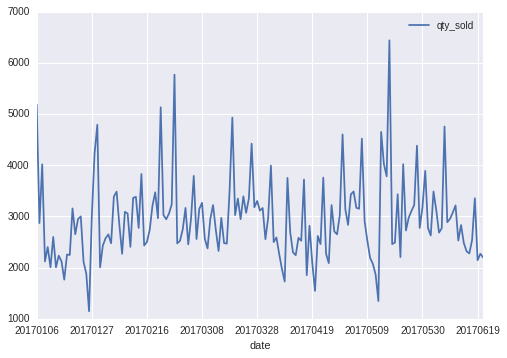

In [9]:
ad.sort_values(by='date',inplace=True)
ad.date = ad.date.astype(str)
print ('Std in dependent: %.2f' % ad.qty_sold.std())
ad.plot(x="date", y="qty_sold", kind="line")

In [ ]:
bi=ad[['date','qty_sold','pi_rm']]
bi.set_index('date',inplace=True)
#data_roadster_tshirts.plot(x="date", y="total_units",secondary_y="lv_share", kind="line")
bi.plot(subplots=True)

In [ ]:
cor=d.drop('qty_sold',axis=1).corr()
cor.to_csv('/data/pratik/tensor/corr.csv')
cor

In [ ]:
for i in d._get_numeric_data().columns:
    sns.jointplot(x=i, y="qty_sold", data=ad,kind="reg")

In [15]:
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
d=ad[['date','qty_sold','output_td','output_td_diff','lc_share_pltf','live_styles','presale_flag','sessions']]
      #,'lc_share_pltf','lp_screens','pi_rm'
      #'output_cd','sessions','brokeness','styles_age_180plus','live_styles','lp_pdp_conversion']]
train, test= train_test_split(d, test_size=0.2, random_state=0)
y_train = train.qty_sold
X_train = train.drop(['qty_sold','date'],axis=1)

y_test = test.qty_sold
X_test = test.drop(['qty_sold','date'],axis=1)

In [13]:
def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [18]:
models1 = { 
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'XGBRegressor': XGBRegressor()
}

params1 = { 
    'LinearRegression': { },
    'RandomForestRegressor': { 'n_estimators':[50,100,200],'max_depth':[3,4,5,6] },
    'GradientBoostingRegressor':  { 'n_estimators':[50,100,200],'max_depth':[3,4,5,6] ,'random_state':[0]},
    'XGBRegressor': { 'booster':['gbtree', 'gblinear'] }
}

In [ ]:
mape_scorer=make_scorer(mape,greater_is_better=False)
selection= EstimatorSelectionHelper(models1, params1)
selection.fit(X_train,y_train, cv=20, n_jobs=-1,scoring=mape_scorer)

In [20]:
gs_eval=selection.score_summary()
best_est=gs_eval.loc[1,'estimator']
gs_eval

estimator min_score mean_score max_score std_score  \
22      RandomForestRegressor  -25.7706   -16.2044  -7.06926   4.33212   
26      RandomForestRegressor   -25.796   -16.2541   -6.9177   4.31975   
24      RandomForestRegressor  -25.5685   -16.2744  -6.60684   4.38648   
25      RandomForestRegressor  -25.9227   -16.3472   -7.0904   4.34694   
23      RandomForestRegressor  -26.4987   -16.4168  -6.85064   4.52636   
21      RandomForestRegressor  -26.3402   -16.4622  -7.28231   4.39947   
6   GradientBoostingRegressor  -23.7496   -16.4632  -4.54848   4.83719   
18      RandomForestRegressor  -26.1442   -16.5441  -8.15718   4.36888   
12           LinearRegression  -28.1572   -16.5481  -10.7215   4.69258   
19      RandomForestRegressor   -26.204   -16.6286  -8.56504   4.13851   
20      RandomForestRegressor  -26.1741   -16.6296  -8.35169   4.17505   
17      RandomForestRegressor  -26.5586   -16.7257  -9.11995    4.2398   
16      RandomForestRegressor  -26.8736     -16.73  -9.34625   4.22035   
15      RandomForestRegressor  -27.1609   -16.7642   -9.0688    4.2519   
7   GradientBoostingRegressor  -24.0146   -16.8941  -4.95017   4.83308   
9   GradientBoostingRegressor  -31.3275   -16.9582  -5.07572   6.16522   
8   GradientBoostingRegressor  -24.0999    -16.964  -5.06652   4.83039   
10  GradientBoostingRegressor  -31.2883   -17.0654  -5.25305   6.12223   
3   GradientBoostingRegressor  -25.8312   -17.0765  -6.80206   4.84308   
11  GradientBoostingRegressor  -31.3363   -17.0817  -5.23949   6.14174   
14               XGBRegressor  -28.0901   -17.1929   -10.147   5.22023   
0   GradientBoostingRegressor  -24.4856   -17.3905  -7.31052   4.51832   
13               XGBRegressor  -22.9737   -17.4922  -7.91445   4.39021   
4   GradientBoostingRegressor  -26.7723   -17.5666  -6.71205   5.09387   
5   GradientBoostingRegressor  -27.0454   -17.8076  -6.80566   5.15876   
1   GradientBoostingRegressor  -24.1957   -17.9978  -7.50103    4.3968   
2   GradientBoostingRegressor   -24.415   -18.6578  -7.68479   4.44576   

     booster max_depth n_estimators random_state  
22       NaN         5          100          NaN  
26       NaN         6          200          NaN  
24       NaN         6           50          NaN  
25       NaN         6          100          NaN  
23       NaN         5          200          NaN  
21       NaN         5           50          NaN  
6        NaN         5           50            0  
18       NaN         4           50          NaN  
12       NaN       NaN          NaN          NaN  
19       NaN         4          100          NaN  
20       NaN         4          200          NaN  
17       NaN         3          200          NaN  
16       NaN         3          100          NaN  
15       NaN         3           50          NaN  
7        NaN         5          100            0  
9        NaN         6           50            0  
8        NaN         5          200            0  
10       NaN         6          100            0  
3        NaN         4           50            0  
11       NaN         6          200            0  
14  gblinear       NaN          NaN          NaN  
0        NaN         3           50            0  
13    gbtree       NaN          NaN          NaN  
4        NaN         4          100            0  
5        NaN         4          200            0  
1        NaN         3          100            0  
2        NaN         3          200            0

In [1]:
selection.grid_searches[best_est].grid_scores_
#["RandomForestRegressor"]

NameError: name 'selection' is not defined

Validation MAPE: 17.52


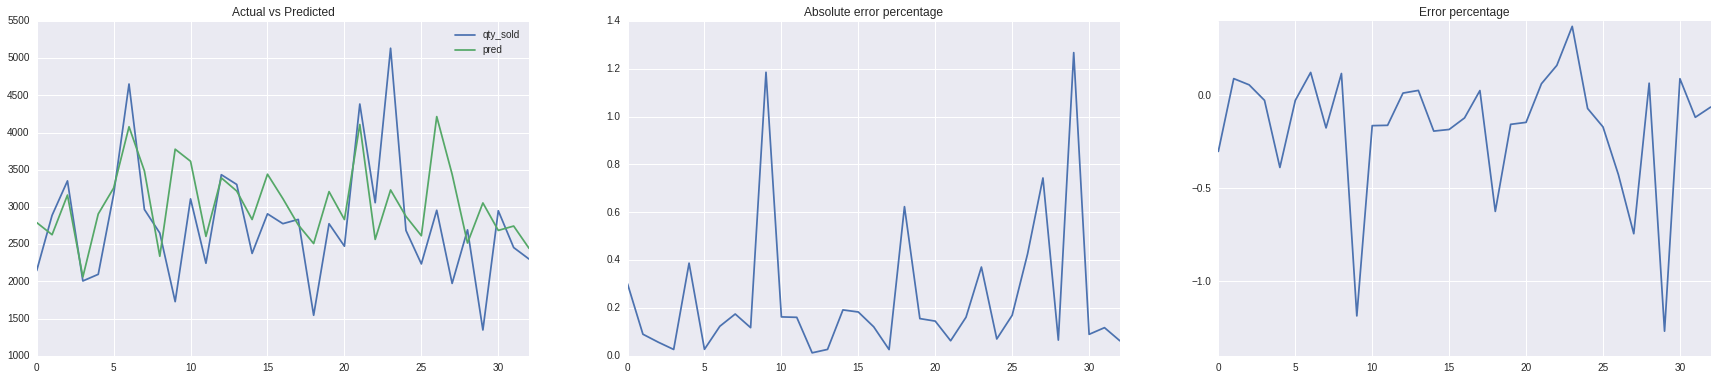

In [23]:
test_est=selection.grid_searches[best_est].best_estimator_
print( 'Validation MAPE: %0.2f' % mape(test_est.predict(X_test), y_test))
pred=pd.concat([test.date.reset_index(),y_test.reset_index(),pd.DataFrame(test_est.predict(X_test),columns=['pred'])], axis=1)
pred['ape']=np.abs((pred['qty_sold'] - pred['pred']) / pred['qty_sold'])
pred['ae']=(pred['qty_sold'] - pred['pred']) / pred['qty_sold']
fig, axs = plt.subplots(ncols=3,figsize=(30, 6))
pred[['qty_sold','pred']].plot(kind='line',ax=axs[0],title="Actual vs Predicted")
pred['ape'].plot(kind='line',ax=axs[1],title="Absolute error percentage")
pred['ae'].plot(kind='line',ax=axs[2],title="Error percentage")

In [ ]:
X.describe(percentiles=[.01,.05,.1,.15,.2,.3,.4,.5,.6,.7,.8,.9,.95,.97,.99]).transpose()

In [ ]:
m1 = LinearRegression()
print "Linear Regression"
m1.fit(X_train,y_train)
print("Root Mean squared error: %.2f"
      % math.sqrt(np.mean((m1.predict(X_test) - y_test) ** 2)))
# Explained variance score: 1 is perfect prediction
print( 'Training MAE: %0.2f' % metrics.mean_absolute_error(m1.predict(X_train), y_train))
print( 'Validation MAE: %0.2f' % metrics.mean_absolute_error(m1.predict(X_test), y_test))
print('Variance score: %.2f' % m1.score(X_test, y_test))
print( 'R2 score : %0.2f'% metrics.r2_score(m1.predict(X_test), y_test) )
print( 'Training MAPE: %0.2f' % mape(m1.predict(X_train), y_train))
print( 'Validation MAPE: %0.2f' % mape(m1.predict(X_test), y_test))
pred=pd.concat([test.date.reset_index(),y_test.reset_index(),pd.DataFrame(m1.predict(X_test),columns=['pred'])], axis=1)
pred['ape']=np.abs((pred['qty_sold'] - pred['pred']) / pred['qty_sold'])
pred['ae']=(pred['qty_sold'] - pred['pred']) / pred['qty_sold']
fig, axs = plt.subplots(ncols=3,figsize=(30, 6))
pred[['qty_sold','pred']].plot(kind='line',ax=axs[0],title="Actual vs Predicted")
pred['ape'].plot(kind='line',ax=axs[1],title="Absolute error percentage")
pred['ae'].plot(kind='line',ax=axs[2],title="Error percentage")
dd=pred.merge(ad.drop('qty_sold',axis=1),on='date',how='left')
dd.to_csv('dd/dd_dk_watches_lr.csv',index=False)


In [ ]:
m1.coef_

In [ ]:
#test[test['date'].isin(pred[pred['ape']>0.17]['date'])].sort_values(by='date')

pd.concat([test.reset_index(),pred['pred']],axis=1)

In [ ]:
m5 = RandomForestRegressor(n_estimators=100,max_depth=7)
print "Random Forrest Regression"
m5.fit(X_train,y_train)
print("Root Mean squared error: %.2f"
      % math.sqrt(np.mean((m5.predict(X_test) - y_test) ** 2)))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % m5.score(X_test, y_test))
print( 'R2 score : %0.2f'% metrics.r2_score(m5.predict(X_test), y_test) )
print( 'Training MAE: %0.2f' % metrics.mean_absolute_error(m5.predict(X_train), y_train))
print( 'Validation MAE: %0.2f' % metrics.mean_absolute_error(m5.predict(X_test), y_test))
print( 'Training MAPE: %0.2f' % mape(m5.predict(X_train), y_train))
print( 'Validation MAPE: %0.2f' % mape(m5.predict(X_test), y_test))
pred=pd.concat([test.date.reset_index(),y_test.reset_index(),pd.DataFrame(m5.predict(X_test),columns=['pred'])], axis=1)
pred['ape']=np.abs((pred['qty_sold'] - pred['pred']) / pred['qty_sold'])
pred['ae']=(pred['qty_sold'] - pred['pred']) / pred['qty_sold']
fig, axs = plt.subplots(ncols=3,figsize=(30, 6))
pred[['qty_sold','pred']].plot(kind='line',ax=axs[0],title="Actual vs Predicted")
pred['ape'].plot(kind='line',ax=axs[1],title="Absolute error percentage")
pred['ae'].plot(kind='line',ax=axs[2],title="Error percentage")
dd=pred.merge(ad.drop('qty_sold',axis=1),on='date',how='left')
dd.to_csv('dd/dd_dk_watches.csv',index=False)

In [ ]:
m6 = GradientBoostingRegressor(n_estimators=100,max_depth=6, random_state=0)
print "Gradient Boosting Tree Regression"
m6.fit(X_train,y_train)
print("Root Mean squared error: %.2f"
      % math.sqrt(np.mean((m6.predict(X_test) - y_test) ** 2)))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % m6.score(X_test, y_test))
print( 'R2 score : %0.2f'% metrics.r2_score(m6.predict(X_test), y_test) )
print( 'Training MAE: %0.2f' % metrics.mean_absolute_error(m6.predict(X_train), y_train))
print( 'Validation MAE: %0.2f' % metrics.mean_absolute_error(m6.predict(X_test), y_test))
print( 'Training MAPE: %0.2f' % mape(m6.predict(X_train), y_train))
print( 'Validation MAPE: %0.2f' % mape(m6.predict(X_test), y_test))
pred=pd.concat([test.date.reset_index(),y_test.reset_index(),pd.DataFrame(m6.predict(X_test),columns=['pred'])], axis=1)
pred['ape']=np.abs((pred['qty_sold'] - pred['pred']) / pred['qty_sold'])
pred['ae']=(pred['qty_sold'] - pred['pred']) / pred['qty_sold']
fig, axs = plt.subplots(ncols=3,figsize=(30, 6))
pred[['qty_sold','pred']].plot(kind='line',ax=axs[0],title="Actual vs Predicted")
pred['ape'].plot(kind='line',ax=axs[1],title="Absolute error percentage")
pred['ae'].plot(kind='line',ax=axs[2],title="Error percentage")

In [ ]:
m9 = XGBRegressor()
print "XGBoost"
m9.fit(X_train,y_train)
print("Root Mean squared error: %.2f"
      % math.sqrt(np.mean((m9.predict(X_test) - y_test) ** 2)))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % m9.score(X_test, y_test))
print( 'R2 score : %0.2f'% metrics.r2_score(m9.predict(X_test), y_test) )
print( 'Training MAE: %0.2f' % metrics.mean_absolute_error(m9.predict(X_train), y_train))
print( 'Validation MAE: %0.2f' % metrics.mean_absolute_error(m9.predict(X_test), y_test))
print( 'Training MAPE: %0.2f' % mape(m9.predict(X_train), y_train))
print( 'Validation MAPE: %0.2f' % mape(m9.predict(X_test), y_test))
pred=pd.concat([test.date.reset_index(),y_test.reset_index(),pd.DataFrame(m9.predict(X_test),columns=['pred'])], axis=1)
pred['ape']=np.abs((pred['qty_sold'] - pred['pred']) / pred['qty_sold'])
pred['ae']=(pred['qty_sold'] - pred['pred']) / pred['qty_sold']
fig, axs = plt.subplots(ncols=3,figsize=(30, 6))
pred[['qty_sold','pred']].plot(kind='line',ax=axs[0],title="Actual vs Predicted")
pred['ape'].plot(kind='line',ax=axs[1],title="Absolute error percentage")
pred['ae'].plot(kind='line',ax=axs[2],title="Error percentage")

In [ ]:
dd=pred.merge(ad.drop('qty_sold',axis=1),on='date',how='left')

In [ ]:
dd=pred.merge(ad.drop('qty_sold',axis=1),on='date',how='left')
dd.to_csv('dd.csv',index=False)

In [ ]:
scalerX = StandardScaler()  
scalerY = StandardScaler()  
# Don't cheat - fit only on training data
X_tr = scalerX.fit_transform(X_train)
X_te = scalerX.transform(X_test)
# apply same transformation to test data
y_tr = scalerY.fit_transform(y_train)
y_te = scalerY.transform(y_test)

In [ ]:
m4 = linear_model.SGDRegressor (loss="epsilon_insensitive", penalty="l2")
print "Stochastic Gradient Descent Regression"
m4.fit(X_tr,y_tr)
print("Root Mean squared error: %.2f"
      % math.sqrt(np.mean((m4.predict(X_te) - y_te) ** 2)))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % m4.score(X_te, y_te))
print( 'R2 score : %0.2f'% metrics.r2_score(m4.predict(X_te), y_te) )
print( 'Training MAPE: %0.2f' % mape(scalerY.inverse_transform(m4.predict(X_tr)), scalerY.inverse_transform(y_tr)))
print( 'Validation MAPE: %0.2f' % mape(scalerY.inverse_transform(m4.predict(X_te)), scalerY.inverse_transform(y_te)))
pred=pd.concat([test.date.reset_index(),y_test.reset_index(),pd.DataFrame(scalerY.inverse_transform(m4.predict(X_te)),columns=['pred'])], axis=1)
pred['ape']=np.abs((pred['qty_sold'] - pred['pred']) / pred['qty_sold'])
pred['ae']=(pred['qty_sold'] - pred['pred']) / pred['qty_sold']
fig, axs = plt.subplots(ncols=3,figsize=(30, 6))
pred[['qty_sold','pred']].plot(kind='line',ax=axs[0],title="Actual vs Predicted")
pred['ape'].plot(kind='line',ax=axs[1],title="Absolute error percentage")
pred['ae'].plot(kind='line',ax=axs[2],title="Error percentage")

In [ ]:
m7 = svm.SVR(C=1, epsilon=0.001)
print "Linear SVM"
m7.fit(X_tr,y_tr)
print("Root Mean squared error: %.2f"
      % math.sqrt(np.mean((m7.predict(X_te) - y_te) ** 2)))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % m7.score(X_te, y_te))
print( 'R2 score : %0.2f'% metrics.r2_score(m7.predict(X_te), y_te) )
print( 'Training MAPE: %0.2f' % mape(scalerY.inverse_transform(m7.predict(X_tr)), scalerY.inverse_transform(y_tr)))
print( 'Validation MAPE: %0.2f' % mape(scalerY.inverse_transform(m7.predict(X_te)), scalerY.inverse_transform(y_te)))
pred=pd.concat([test.date.reset_index(),y_test.reset_index(),pd.DataFrame(scalerY.inverse_transform(m7.predict(X_te)),columns=['pred'])], axis=1)
pred['ape']=np.abs((pred['qty_sold'] - pred['pred']) / pred['qty_sold'])
pred['ae']=(pred['qty_sold'] - pred['pred']) / pred['qty_sold']
fig, axs = plt.subplots(ncols=3,figsize=(30, 6))
pred[['qty_sold','pred']].plot(kind='line',ax=axs[0],title="Actual vs Predicted")
pred['ape'].plot(kind='line',ax=axs[1],title="Absolute error percentage")
pred['ae'].plot(kind='line',ax=axs[2],title="Error percentage")

In [ ]:
m8 = MLPRegressor(alpha=0.01,learning_rate='adaptive',verbose=False,hidden_layer_sizes=(11,8,4,2), random_state=1)
print "MLP nueral network"
m8.fit(X_tr,y_tr)
print("Root Mean squared error: %.2f"
      % math.sqrt(np.mean((m8.predict(X_te) - y_te) ** 2)))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % m8.score(X_te, y_te))
print( 'R2 score : %0.2f'% metrics.r2_score(m8.predict(X_te), y_te) )
print( 'Training MAPE: %0.2f' % mape(scalerY.inverse_transform(m8.predict(X_tr)), scalerY.inverse_transform(y_tr)))
print( 'Validation MAPE: %0.2f' % mape(scalerY.inverse_transform(m8.predict(X_te)), scalerY.inverse_transform(y_te)))
pred=pd.concat([test.date.reset_index(),y_test.reset_index(),pd.DataFrame(scalerY.inverse_transform(m8.predict(X_te)),columns=['pred'])], axis=1)
pred['ape']=np.abs((pred['qty_sold'] - pred['pred']) / pred['qty_sold'])
pred['ae']=(pred['qty_sold'] - pred['pred']) / pred['qty_sold']
fig, axs = plt.subplots(ncols=3,figsize=(30, 6))
pred[['qty_sold','pred']].plot(kind='line',ax=axs[0],title="Actual vs Predicted")
pred['ape'].plot(kind='line',ax=axs[1],title="Absolute error percentage")
pred['ae'].plot(kind='line',ax=axs[2],title="Error percentage")

In [ ]:
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(14, input_dim=11, kernel_initializer='normal', activation='relu'))
    model.add(Dense(7, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_absolute_percentage_error', optimizer='adam')
    return model
m10 = KerasRegressor(build_fn=create_baseline, nb_epoch=200, batch_size=10, verbose=0)

In [ ]:
print "Keras nueral network"
m10.fit(X_train.as_matrix(),y_train.as_matrix())
print("Root Mean squared error: %.2f"
      % math.sqrt(np.mean((m10.predict(X_test.as_matrix()) - y_test) ** 2)))
# Explained variance score: 1 is perfect prediction
print( 'Training MAE: %0.2f' % metrics.mean_absolute_error(m10.predict(X_train.as_matrix()), y_train))
print( 'Validation MAE: %0.2f' % metrics.mean_absolute_error(m10.predict(X_test.as_matrix()), y_test))
#print('Variance score: %.2f' % m10.score(X_test, y_test))
print( 'R2 score : %0.2f'% metrics.r2_score(m10.predict(X_test.as_matrix()), y_test) )
print( 'Training MAPE: %0.2f' % mape(m10.predict(X_train.as_matrix()), y_train))
print( 'Validation MAPE: %0.2f' % mape(m10.predict(X_test.as_matrix()), y_test))
pred=pd.concat([test.date.reset_index(),y_test.reset_index(),pd.DataFrame(m10.predict(X_test.as_matrix()),columns=['pred'])], axis=1)
pred['ape']=np.abs((pred['qty_sold'] - pred['pred']) / pred['qty_sold'])
pred['ae']=(pred['qty_sold'] - pred['pred']) / pred['qty_sold']
fig, axs = plt.subplots(ncols=3,figsize=(30, 6))
pred[['qty_sold','pred']].plot(kind='line',ax=axs[0],title="Actual vs Predicted")
pred['ape'].plot(kind='line',ax=axs[1],title="Absolute error percentage")
pred['ae'].plot(kind='line',ax=axs[2],title="Error percentage")

In [ ]:
xgb.plot_importance(m9)

In [ ]:
xgb.plot_tree(m9)

In [ ]:
from sklearn.tree import export_graphviz
import os
export_graphviz(m5.estimators_[0],
                feature_names=X.columns,
                filled=True,
                rounded=True)
os.system('dot -Tpng tree.dot -o tree.png')

In [ ]:
importance = m5.feature_importances_
importance = pd.DataFrame(importance, index=X_train.columns, 
                          columns=["Importance"])

importance["Std"] = np.std([m5.feature_importances_
                            for tree in m5.estimators_], axis=0)

x = range(importance.shape[0])
y = importance.ix[:, 0]
yerr = importance.ix[:, 1]

plt.bar(x, y, yerr=yerr, align="center")

plt.show()

In [ ]:
x=sm.add_constant(X_train)
linear_mod = sm.OLS(y_train, x).fit()
print linear_mod.summary()